In [29]:
import pandas as pd
import numpy as np
import tensorflow as tf
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

nltk.download('stopwords')
nltk.download('punkt')

file_path = "/content/2021-2024 final.xlsx"

df = pd.read_excel(file_path)

df.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,date,headline,decision,description
0,02-01-2021,Covishield moves closer to roll-out; SII gets ...,Neutral,India would need 30 million doses in the first...
1,02-01-2021,"GST mop-up at record high, surges to Rs 1.15 t...",Neutral,The collection rose for the fourth consecutive...
2,02-01-2021,Mahindra and Ford Motor Co call off proposed J...,Neutral,Mahindra also expects to close deal with a pot...
3,02-01-2021,"Sportcars to EVs, new wheels on the block set ...",Neutral,"The latest sportscars, sedans, SUVs and electr..."
4,04-01-2021,"Serum, Bharat Biotech vaccines get restricted ...",Neutral,While the Oxford-AstraZeneca vaccine made by S...


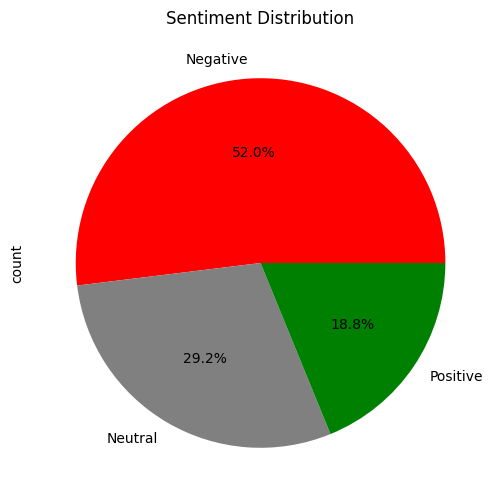

In [30]:
sentiment_map = {"Negative": 0, "Neutral": 1, "Positive": 2}
df["label"] = df["decision"].map(sentiment_map)

plt.figure(figsize=(6, 6))
df["label"].value_counts().plot.pie(autopct='%1.1f%%', labels=["Negative", "Neutral", "Positive"], colors=["red", "gray", "green"])
plt.title("Sentiment Distribution")
plt.show()



In [31]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

# preprocessing
df["headline"] = df["headline"].apply(preprocess_text)

MAX_NUM_WORDS = 10000
MAX_SEQ_LENGTH = 50

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df["headline"])
sequences = tokenizer.texts_to_sequences(df["headline"])
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH, padding="post")

print(f"Example padded sequence:\n{padded_sequences[0]}")


Example padded sequence:
[ 616  617 2283  776 1153   75 1405  365  214    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


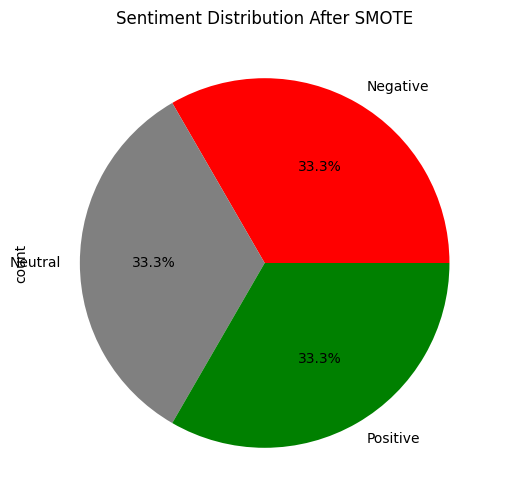

In [32]:
X_resampled, y_resampled = SMOTE().fit_resample(padded_sequences, df["label"])

plt.figure(figsize=(6, 6))
pd.Series(y_resampled).value_counts().plot.pie(autopct='%1.1f%%', labels=["Negative", "Neutral", "Positive"], colors=["red", "gray", "green"])
plt.title("Sentiment Distribution After SMOTE")
plt.show()


In [33]:
embedding_dim = 100

cnn_model = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS, output_dim=embedding_dim, input_length=MAX_SEQ_LENGTH),
    Conv1D(128, 5, activation="relu"),
    GlobalMaxPooling1D(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dense(32, activation="relu")
])
cnn_features = cnn_model.predict(X_resampled)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


In [34]:
xgb_classifier = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_classifier.fit(cnn_features, y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)


Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.82      0.84       432
     Neutral       0.83      0.81      0.82       381
    Positive       0.79      0.87      0.83       338

    accuracy                           0.83      1151
   macro avg       0.83      0.83      0.83      1151
weighted avg       0.83      0.83      0.83      1151



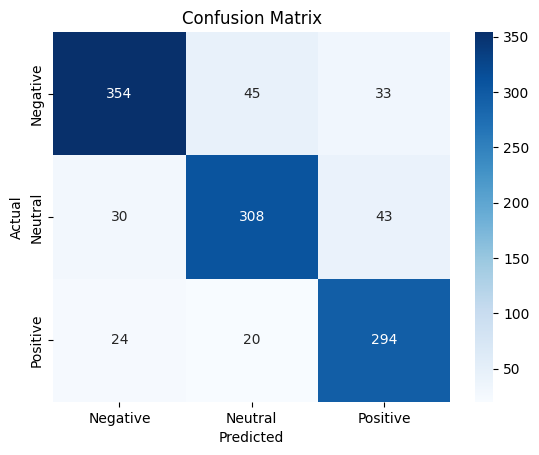

In [35]:
X_train, X_test, y_train, y_test = train_test_split(cnn_features, y_resampled, test_size=0.2, random_state=42)
y_pred = xgb_classifier.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Negative", "Neutral", "Positive"]))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [38]:
def predict_sentiment(sentence):
    processed_sentence = preprocess_text(sentence)
    sequence = tokenizer.texts_to_sequences([processed_sentence])
    padded_sequence = pad_sequences(sequence, maxlen=MAX_SEQ_LENGTH, padding="post")
    cnn_feature = cnn_model.predict(padded_sequence, verbose=0)
    prediction = xgb_classifier.predict(cnn_feature)[0]
    sentiment_labels = {0: "Negative", 1: "Neutral", 2: "Positive"}
    return sentiment_labels[prediction]

sample_sentence = "Tesla marks India entry with new office in Bengaluru, names three directors"
predicted_sentiment = predict_sentiment(sample_sentence)
print(f"Predicted Sentiment: {predicted_sentiment}")


Predicted Sentiment: Neutral
